In [1]:
import torch 
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
from tqdm import tqdm
from functools import partial

Load feature extractor and pretrained vision transformer 

In [2]:
classes = os.listdir("../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train")
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [3]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [4]:
train_dir = "../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
test_dir = "../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test"

PyTorch Dataset

In [5]:
class Standford_Car_Dataset(Dataset):
    
    def __init__(self, root, feature_extractor, labels):
        self.feature_extractor = feature_extractor 
        self.files = []
        self.labels = labels
        
        # get all the subdirectories in the root folder
        subdirs = sorted(os.listdir(root))
        
        for subdir in subdirs:
            for path, _, files in os.walk(os.path.join(root, subdir)):
                for file in files:
                    # append both the filename and label
                    self.files.append((os.path.join(root, subdir, file), subdir))
    
    def __getitem__(self, index):
        img, label = self.files[index % len(self.files)]
        img = Image.open(img).convert("RGB")
        img = self.feature_extractor(img, return_tensors="pt")
        img["labels"] = torch.tensor(self.labels.index(label))
        return img
    
    def __len__(self):
        return len(self.files)

Load datasets

In [6]:
train_dataset = Standford_Car_Dataset(train_dir, feature_extractor, classes)
test_dataset = Standford_Car_Dataset(test_dir, feature_extractor, classes)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [6041, 2000])

In [7]:
batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

visualize training images

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_epochs = 20
lr = 2e-4
eval_steps = 100
record_steps= 10
save_checkpoint = 5

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(classes),
                                                   id2label={str(i): c for i, c in enumerate(classes)},
                                                   label2id={c: str(i) for i, c in enumerate(classes)},
                                                   ignore_mismatched_sizes=True).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=lr)

# negative log likelihood -> multi-class classification
training_stats_step = 10

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([196, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([196]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optim, step_size=1, gamma=0.6)

In [11]:
def evaluate(model, eval_loader, eval_dataset):
    correct = 0
    eval_loss = []
    
    model.eval()
    for batch in tqdm(eval_loader):
        # extracting images and labels from batch 
        batch_images = batch["pixel_values"].squeeze(1).to(device)
        batch_labels = batch["labels"].to(device)
        
        # not training the model
        with torch.no_grad():
            outputs = model(pixel_values=batch_images, labels=batch_labels)
            loss = outputs[0]
            eval_loss.append(loss.item())
            correct += (torch.argmax(outputs["logits"], dim=1) == batch_labels).sum().item()
    
    # return eval accuracy and loss
    accuracy = (100 * correct / len(eval_dataset))
    avg_loss = (sum(eval_loss) / len(epoch_loss))
    
    return accuracy, avg_loss

pytorch training loop

In [12]:
tqdm = partial(tqdm, position=0, leave=True)

In [13]:
training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # storing loss and accuracy across the epoch
    epoch_loss = []
    epoch_acc = []
    
    print(f"Epoch {epoch}")
    for index, batch in enumerate(tqdm(train_loader)):
        model.train()
        optim.zero_grad()

        # extract images and labels from batch
        batch_images = batch["pixel_values"].squeeze(1).to(device)
        batch_labels = batch["labels"].to(device)
        size = len(batch_images)
        
        outputs = model(pixel_values=batch_images, labels=batch_labels)
        
        loss = outputs[0]
        epoch_loss.append(loss.item())
        loss.backward()
        optim.step()
        
        correct = (torch.argmax(outputs["logits"], dim=1) == batch_labels).sum().item()
        acc = (100 * correct) / size
        epoch_acc.append(acc)
        
        # log the training metrics
        if index % record_steps == 0:
            training_accuracies.append(acc)
            training_losses.append(loss)
    
    # calculate summary stats for each epoch 
    avg_accuracy = (sum(epoch_acc) / len(epoch_acc))
    avg_loss = (sum(epoch_loss) / len(epoch_loss))
    
    # we decay the loss over time 
    scheduler.step()
    
    # save checkpoints using torchscript 
    if epoch % save_checkpoint == 0:
        model.save_pretrained(f"Epoch {epoch}")
    
    # finding validation accuracy and loss
    val_acc, val_loss = evaluate(model, val_loader, val_dataset)
    test_accuracies.append(val_acc)
    test_losses.append(val_loss)
    
    # summary stats at the end of the episode
    print("evaluating on validation set")
    print(f"val loss: {round(val_loss, 4)}, val acc: {round(val_acc, 4)}%")
    print(f"Epoch: {epoch}  avg loss: {round(avg_loss, 4)} avg acc: {round(avg_accuracy, 4)}%")

Epoch 0


100%|██████████| 63/63 [00:23<00:00,  2.66it/s]


evaluating on validation set
val loss: 0.4777, val acc: 54.95%
Epoch: 0  avg loss: 3.5743 avg acc: 23.3211%
Epoch 1


100%|██████████| 63/63 [00:18<00:00,  3.47it/s]


evaluating on validation set
val loss: 0.2404, val acc: 77.2%
Epoch: 1  avg loss: 0.892 avg acc: 83.9828%
Epoch 2


100%|██████████| 63/63 [00:18<00:00,  3.44it/s]


evaluating on validation set
val loss: 0.1879, val acc: 82.2%
Epoch: 2  avg loss: 0.1761 avg acc: 98.3946%
Epoch 3


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]


evaluating on validation set
val loss: 0.1729, val acc: 83.95%
Epoch: 3  avg loss: 0.0615 avg acc: 99.6324%
Epoch 4


100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


evaluating on validation set
val loss: 0.1692, val acc: 84.35%
Epoch: 4  avg loss: 0.04 avg acc: 99.7672%
Epoch 5


100%|██████████| 63/63 [00:18<00:00,  3.38it/s]


evaluating on validation set
val loss: 0.1664, val acc: 84.45%
Epoch: 5  avg loss: 0.0325 avg acc: 99.7794%
Epoch 6


100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


evaluating on validation set
val loss: 0.1667, val acc: 84.55%
Epoch: 6  avg loss: 0.0288 avg acc: 99.8162%
Epoch 7


100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


evaluating on validation set
val loss: 0.165, val acc: 84.7%
Epoch: 7  avg loss: 0.0266 avg acc: 99.7917%
Epoch 8


100%|██████████| 63/63 [00:18<00:00,  3.35it/s]


evaluating on validation set
val loss: 0.1641, val acc: 84.7%
Epoch: 8  avg loss: 0.0254 avg acc: 99.8039%
Epoch 9


100%|██████████| 63/63 [00:18<00:00,  3.38it/s]


evaluating on validation set
val loss: 0.1638, val acc: 84.65%
Epoch: 9  avg loss: 0.0245 avg acc: 99.7794%
Epoch 10


100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


evaluating on validation set
val loss: 0.1641, val acc: 84.65%
Epoch: 10  avg loss: 0.0239 avg acc: 99.8162%
Epoch 11


100%|██████████| 63/63 [00:18<00:00,  3.45it/s]


evaluating on validation set
val loss: 0.1633, val acc: 84.65%
Epoch: 11  avg loss: 0.0236 avg acc: 99.8284%
Epoch 12


100%|██████████| 63/63 [00:18<00:00,  3.45it/s]


evaluating on validation set
val loss: 0.1635, val acc: 84.65%
Epoch: 12  avg loss: 0.0233 avg acc: 99.8407%
Epoch 13


100%|██████████| 63/63 [00:18<00:00,  3.40it/s]


evaluating on validation set
val loss: 0.1642, val acc: 84.65%
Epoch: 13  avg loss: 0.0232 avg acc: 99.8407%
Epoch 14


100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


evaluating on validation set
val loss: 0.1643, val acc: 84.65%
Epoch: 14  avg loss: 0.0231 avg acc: 99.8407%
Epoch 15


100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


evaluating on validation set
val loss: 0.1637, val acc: 84.65%
Epoch: 15  avg loss: 0.023 avg acc: 99.8529%
Epoch 16


100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


evaluating on validation set
val loss: 0.1637, val acc: 84.65%
Epoch: 16  avg loss: 0.023 avg acc: 99.8529%
Epoch 17


100%|██████████| 63/63 [00:19<00:00,  3.32it/s]


evaluating on validation set
val loss: 0.1633, val acc: 84.65%
Epoch: 17  avg loss: 0.0229 avg acc: 99.8407%
Epoch 18


100%|██████████| 63/63 [00:18<00:00,  3.46it/s]


evaluating on validation set
val loss: 0.1633, val acc: 84.65%
Epoch: 18  avg loss: 0.0229 avg acc: 99.8529%
Epoch 19


100%|██████████| 63/63 [00:18<00:00,  3.44it/s]

evaluating on validation set
val loss: 0.1637, val acc: 84.65%
Epoch: 19  avg loss: 0.0229 avg acc: 99.8529%


In [14]:
test_acc, test_loss = evaluate(model, test_loader, test_dataset)
print(f"testing acc: {round(test_acc, 4)}%, testing loss: {round(test_loss, 4)}%")

100%|██████████| 189/189 [01:12<00:00,  2.60it/s]

testing acc: 83.6948%, testing loss: 0.4979%


In [15]:
training_losses

[tensor(5.4270, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(5.2774, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(5.1485, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(5.0887, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.8825, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.7409, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.5303, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.1230, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.2596, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.9267, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.8756, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.6079, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.7328, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.9371, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.2135, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.2980, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

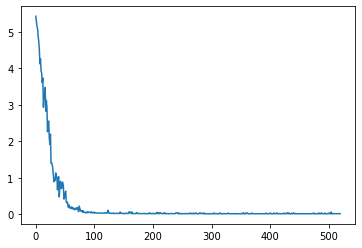

In [16]:
train_losses = [x.item() for x in training_losses]
plt.plot(train_losses)

In [17]:
pick_train_losses = train_losses[::26]

In [18]:
len(pick_train_losses)

20

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


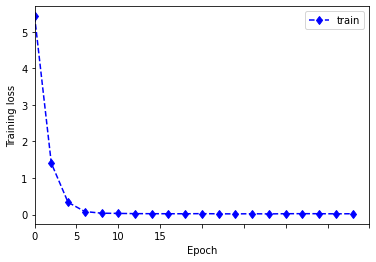

In [19]:
def plot_loss(training_losses, model_name):
    fig, ax = plt.subplots()
    ax.plot(training_losses, 'bd', linestyle='--', label='train')
#     ax.set_title("Train and test accuracies")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training loss')
    x_values = np.arange(0, len(training_losses), step=5)
    ax.set_xticklabels(x_values)
    ax.legend()
    ax.set_xlim((0, 20))
    fig.savefig(f'fig_{model_name}_training_losses.pdf')
plot_loss(pick_train_losses, 'ViT')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":


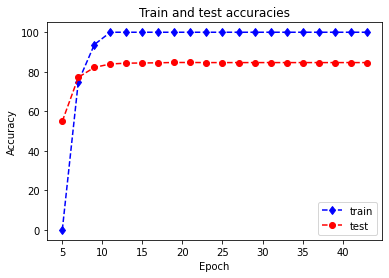

In [20]:
def plot_train_test_accuracies(training_accs, test_accs, model_name):
    fig, ax = plt.subplots()
    ax.plot(training_accs, 'bd', linestyle='--', label='train')
    ax.plot(test_accs, 'ro', linestyle='--', label='test')
    ax.set_title("Train and test accuracies")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    x_values = np.arange(0, len(training_losses), step=5)
    ax.set_xticklabels(x_values)
    ax.legend()
    fig.savefig(f'fig_{model_name}_train_test_accuracies.pdf')

pick_train_accs = training_accuracies[::26]
plot_train_test_accuracies(pick_train_accs, test_accuracies, 'ViT')